# NYC Yellow Taxi Trips

The New York City Taxi & Limousine Commission provides data on trips taken via yellow, green, and for-hire vehicles such as Uber and Lyft. This project focuses on the Yellow Taxi industry. The data is stored in parquet files and will be read into pandas for data manipulation. The goal of this project is to analyze how the industry's network of trips (edges) flows throughout the city based on pickup and dropoff locations (nodes). Utilizing centrality measures such as degree and eigenvector centrality, we aim to identify potential differences in trip patterns based on payment methods, specifically cash versus credit card.

Our hypothesis is that the most important nodes will differ depending on the payment method. For credit card transactions, longer-distance trips, such as those between the city and airports, will likely highlight airport nodes as the most important. For cash transactions, intra-city trips such as those between Times Square and Wall Street—will be more significant, as these trips tend to be shorter, making cash payments more convenient.

It is important to note that the records being used will **only be for January 2024** due to the size of each data file. Also, a data dictionary of what each column represents can be found [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

## Import Trips Data

We can see we have a lot of data that needs to be parsed down for this network analysis. The most important features will be pickup location(**PULocationID**), dropoff location (**DOLocationID**) and payment type (**payment_type**)

In [2]:
trips_df = pd.read_parquet('yellow_tripdata_2024-01.parquet')

In [3]:
trips_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## Import Location Data
We also have each locationID and what borough and zone it represents. 

In [4]:
location_df = pd.read_csv('taxi_zone_lookup.csv')
location_df = location_df.drop(columns='service_zone')
location_df.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


## Data Exploration

### Missing Values

We can see that some columns have missing values such as passenger counts, ratecodeID and airport_fee. Fortunately these columns are not of importance in this analysis.

In [5]:
trips_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

### Total Trips

We have a total of almost 3 million trips taken. We can also see that pickup location **node 132** has the highest amount of trips being picked up from.

In [6]:
trips_df['PULocationID'].count()

np.int64(2964624)

In [7]:
top_pickup_trips = trips_df.groupby('PULocationID')['DOLocationID'].agg(total_trips = 'count').reset_index(drop=False).sort_values(by='total_trips', ascending=False)
top_pickup_trips

,PULocationID,total_trips
126,132,145240
155,161,143471
231,237,142708
230,236,136465
156,162,106717
...,...,...
105,111,1
42,44,1
100,105,1
198,204,1


To have some more clarity of the top 10 trips being picked up from, we will join our location data with it. 

Not surprisingly, JFK Airport has the highest amount of trips being picked up from. However, NYC's other airport, LaGuardia Aiport, falls down to 8th place with Manhattan's Midtown Center coming in 2nd instead. Some reasoning behind this is given how central of a hub Midtown is to all of NYC but definitely raises questions if it is truly as important in the network.

In [8]:
merged_df = pd.merge(top_pickup_trips, location_df, left_on='PULocationID', right_on='LocationID')
merged_df.head(10)

,PULocationID,total_trips,LocationID,Borough,Zone
0,132,145240,132,Queens,JFK Airport
1,161,143471,161,Manhattan,Midtown Center
2,237,142708,237,Manhattan,Upper East Side South
3,236,136465,236,Manhattan,Upper East Side North
4,162,106717,162,Manhattan,Midtown East
5,230,106324,230,Manhattan,Times Sq/Theatre District
6,186,104523,186,Manhattan,Penn Station/Madison Sq West
7,142,104080,142,Manhattan,Lincoln Square East
8,138,89533,138,Queens,LaGuardia Airport
9,239,88474,239,Manhattan,Upper West Side South


Looking at the dropoff locations, we find that the Upper East Side North/South have the highest number of dropoffs in our network. This again raises the question as to which node is the most important in our network. 

In [9]:
top_pickup_trips = trips_df.groupby('DOLocationID')['PULocationID'].agg(total_trips = 'count').reset_index(drop=False).sort_values(by='total_trips', ascending=False)
merged_df = pd.merge(top_pickup_trips, location_df, left_on='DOLocationID', right_on='LocationID')
merged_df.head(10)

,DOLocationID,total_trips,LocationID,Borough,Zone
0,236,142044,236,Manhattan,Upper East Side North
1,237,130249,237,Manhattan,Upper East Side South
2,161,111942,161,Manhattan,Midtown Center
3,230,90603,230,Manhattan,Times Sq/Theatre District
4,142,89673,142,Manhattan,Lincoln Square East
5,239,89105,239,Manhattan,Upper West Side South
6,170,86733,170,Manhattan,Murray Hill
7,162,85238,162,Manhattan,Midtown East
8,141,83562,141,Manhattan,Lenox Hill West
9,68,74517,68,Manhattan,East Chelsea


### Payment Methods

We discover that most trips payment method is 1 (**Credit Card**), with over 2.3 million transactions, followed by 2 (**Cash**) payments of under 0.5 millions transactions. We also see there are other categories such as 3 (**No Charge**) and 4 (**Dispute**). Given the constraints of our analysis, trips not ending with a credit card or cash transaction will be removed.

In [10]:
payment_trips = trips_df.groupby('payment_type')['payment_type'].agg(total = 'count').reset_index(drop=False).sort_values(by='total', ascending=False)
payment_trips

,payment_type,total
1,1,2319046
2,2,439191
0,0,140162
4,4,46628
3,3,19597


## Data Wrangling

We will remove trips that did not end with a credit card or cash transaction. Also, columns not needed in this analysis will be dropped as well.

In [11]:
drop_columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                'RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
               'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
drop_trips_df = trips_df[trips_df['payment_type'].isin([1, 2])].drop(columns=drop_columns)
drop_trips_df.head()

,PULocationID,DOLocationID,payment_type
0,186,79,2
1,140,236,1
2,236,79,1
3,79,211,1
4,211,148,1


Next, we will replace our numeric payment type to its appropriate string value

In [12]:
drop_trips_df['payment_type'] = drop_trips_df['payment_type'].apply(lambda x: 'Credit Card' if x==1 else 'Cash')
drop_trips_df.head()

,PULocationID,DOLocationID,payment_type
0,186,79,Cash
1,140,236,Credit Card
2,236,79,Credit Card
3,79,211,Credit Card
4,211,148,Credit Card


Let's add a column developing trip counts based on a pickup to dropoff location and its payment type. This will be important later on as we will use it as a weight in our network. 

In [13]:
drop_trips_df['trip_count'] = 1
cleaned_trips_df = drop_trips_df.groupby(['PULocationID', 'DOLocationID', 'payment_type'])['trip_count'].agg('count').reset_index()
cleaned_trips_df.head()

,PULocationID,DOLocationID,payment_type,trip_count
0,1,1,Cash,12
1,1,1,Credit Card,229
2,1,6,Credit Card,1
3,1,48,Cash,1
4,1,68,Credit Card,1


## Yellow Taxi Trips (Credit Card)

We will begin our first network graph setup with credit card transactions. We are looking to measure a network's most important nodes using both degree and eigenvector centrality. The graph will be a directed, weighted graph using **trip_counts** as its weights and the direction of a **PULocationID** to **DOLocationID** trip. 

In [14]:
cc_trips = cleaned_trips_df[cleaned_trips_df['payment_type'] == 'Credit Card']
cc_trips.head()

,PULocationID,DOLocationID,payment_type,trip_count
1,1,1,Credit Card,229
2,1,6,Credit Card,1
4,1,68,Credit Card,1
5,1,138,Credit Card,1
6,1,144,Credit Card,1


Most of our nodes are centralized in the center, with a few of them outside of it, probably seen as  outliers as few trips occur between itself and other places. 

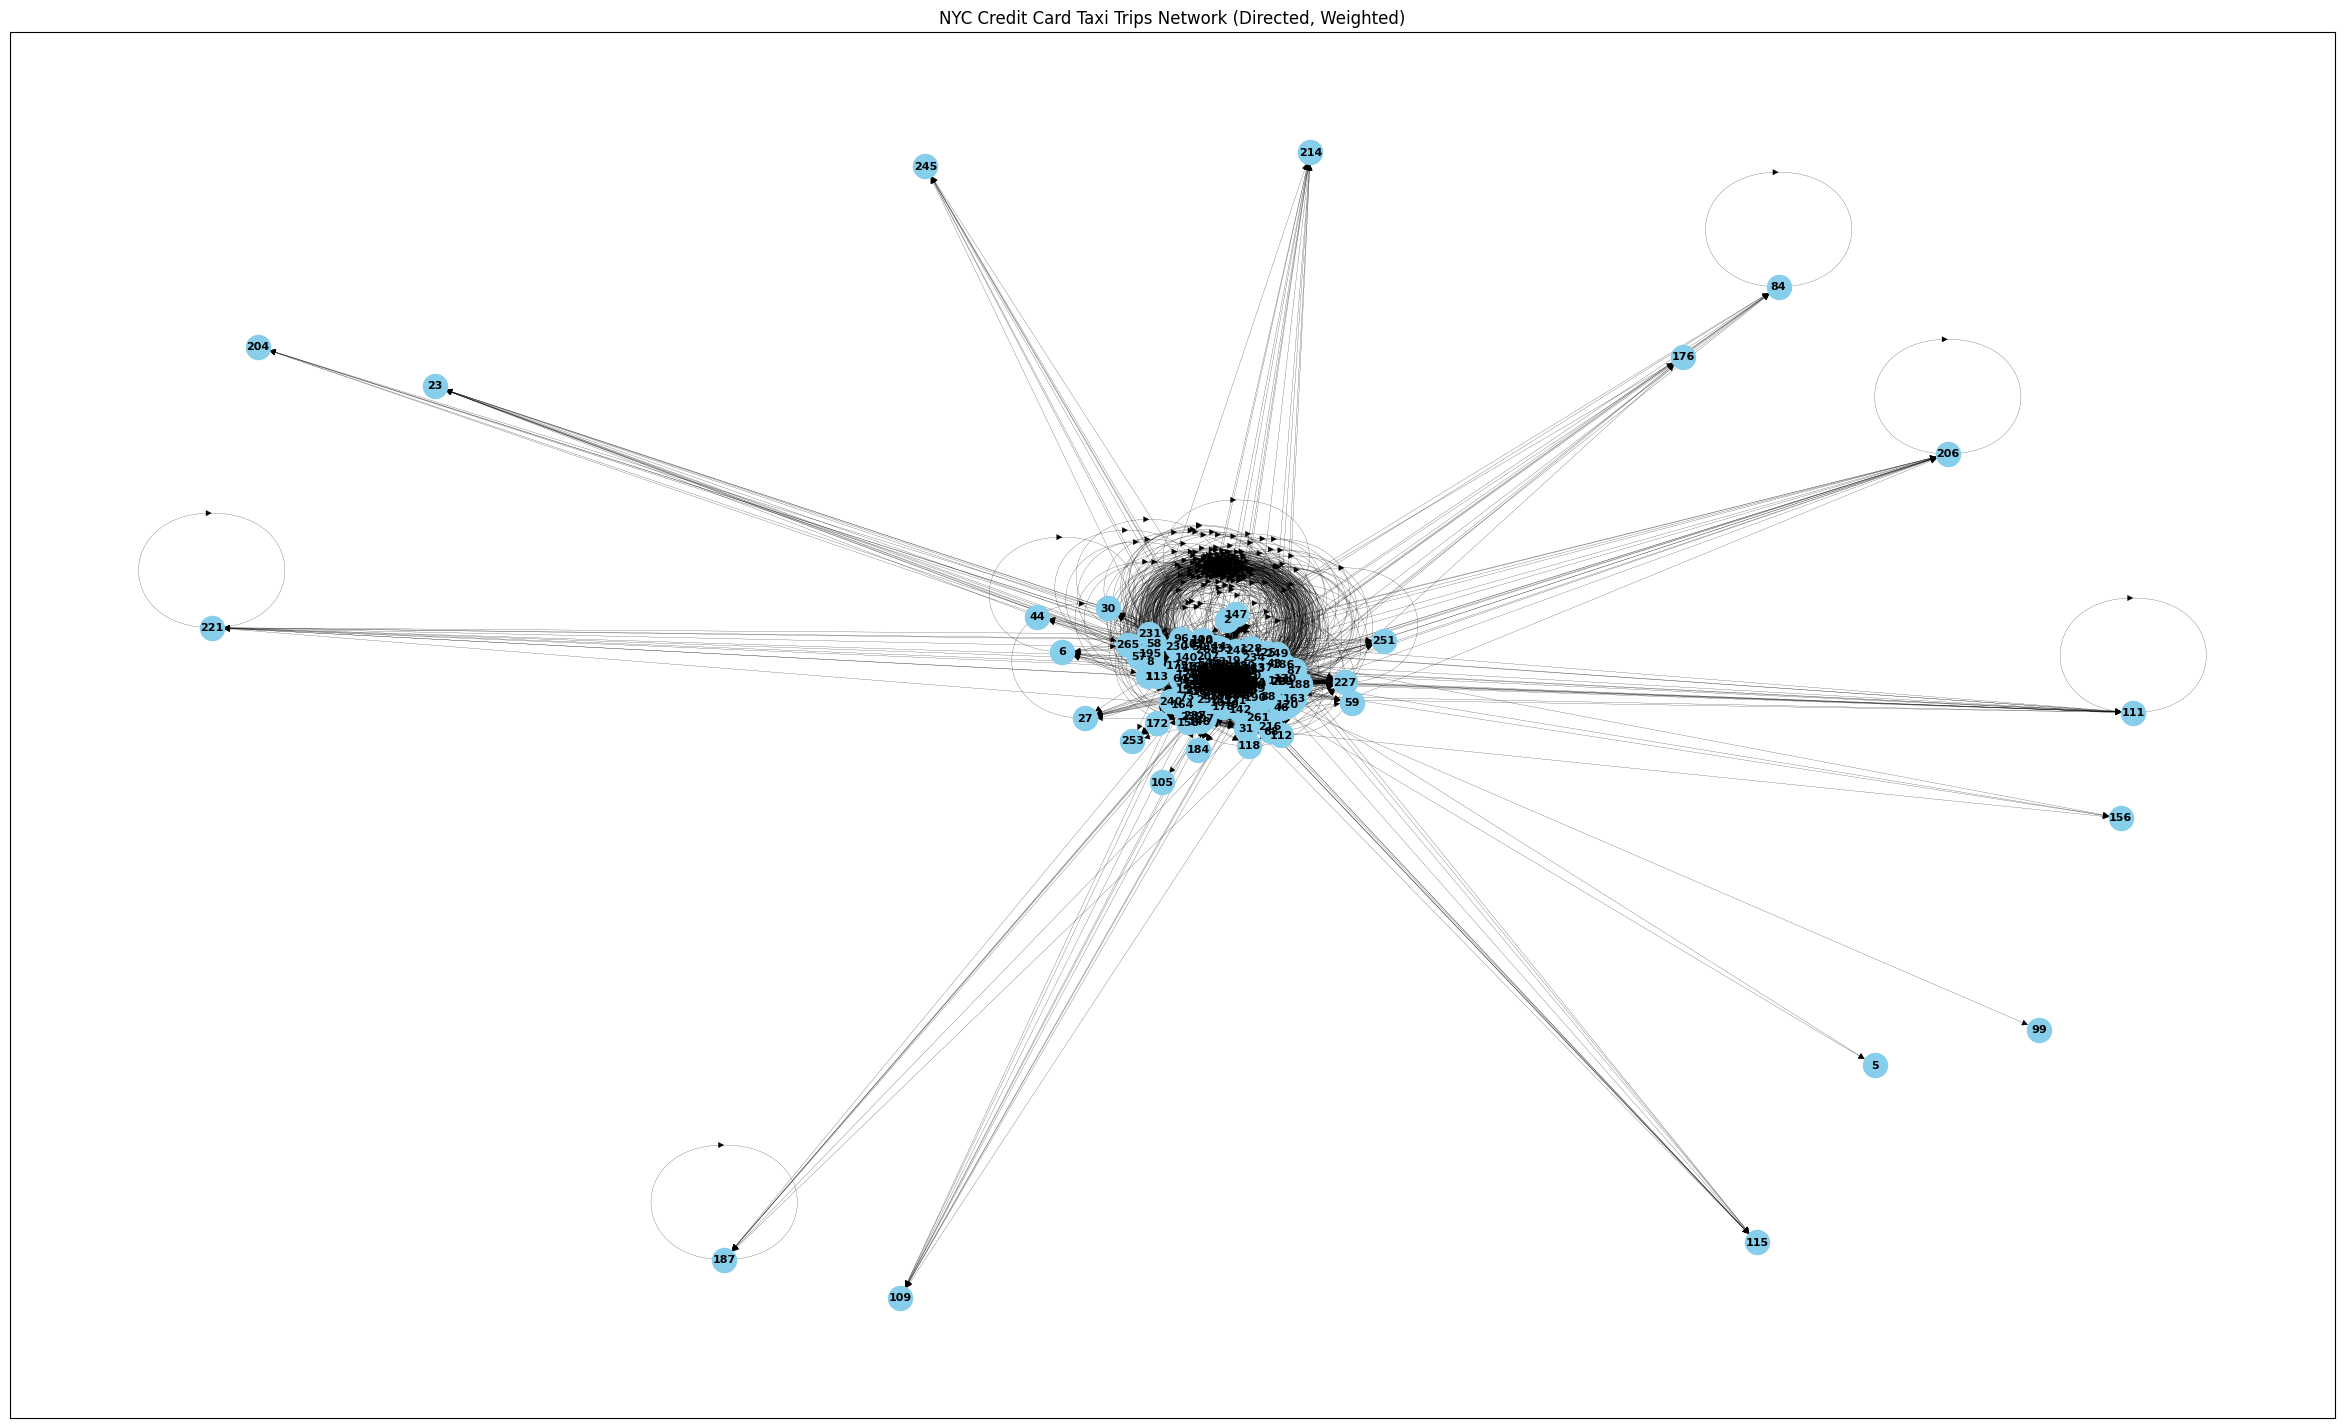

In [15]:
G_credit = nx.from_pandas_edgelist(cc_trips, source='PULocationID', target='DOLocationID', 
                            edge_attr='trip_count', create_using=nx.DiGraph())

pos = nx.spring_layout(G_credit, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw_networkx_nodes(G_credit, pos, node_size=300, node_color="skyblue")
nx.draw_networkx_edges(G_credit, pos, width=0.15)
nx.draw_networkx_labels(G_credit, pos, font_size=8, font_weight="bold")

plt.title("NYC Credit Card Taxi Trips Network (Directed, Weighted)")
plt.show()

### Degree Centrality

Looking at the node with the highest degree centrality, we find that **node 140** is the most important node by this measure and it had 402 edges connected to it. 

In [16]:
top_degree_centrality = max(nx.degree_centrality(G_credit), key=nx.degree_centrality(G_credit).get)
print(f"Highest Degree Centrality: {top_degree_centrality}")
print("Number of Edges:", G_credit.degree(132))

Highest Degree Centrality: 140
Number of Edges: 402


We can see that **node 140** lies around the central cluster of nodes in our graph

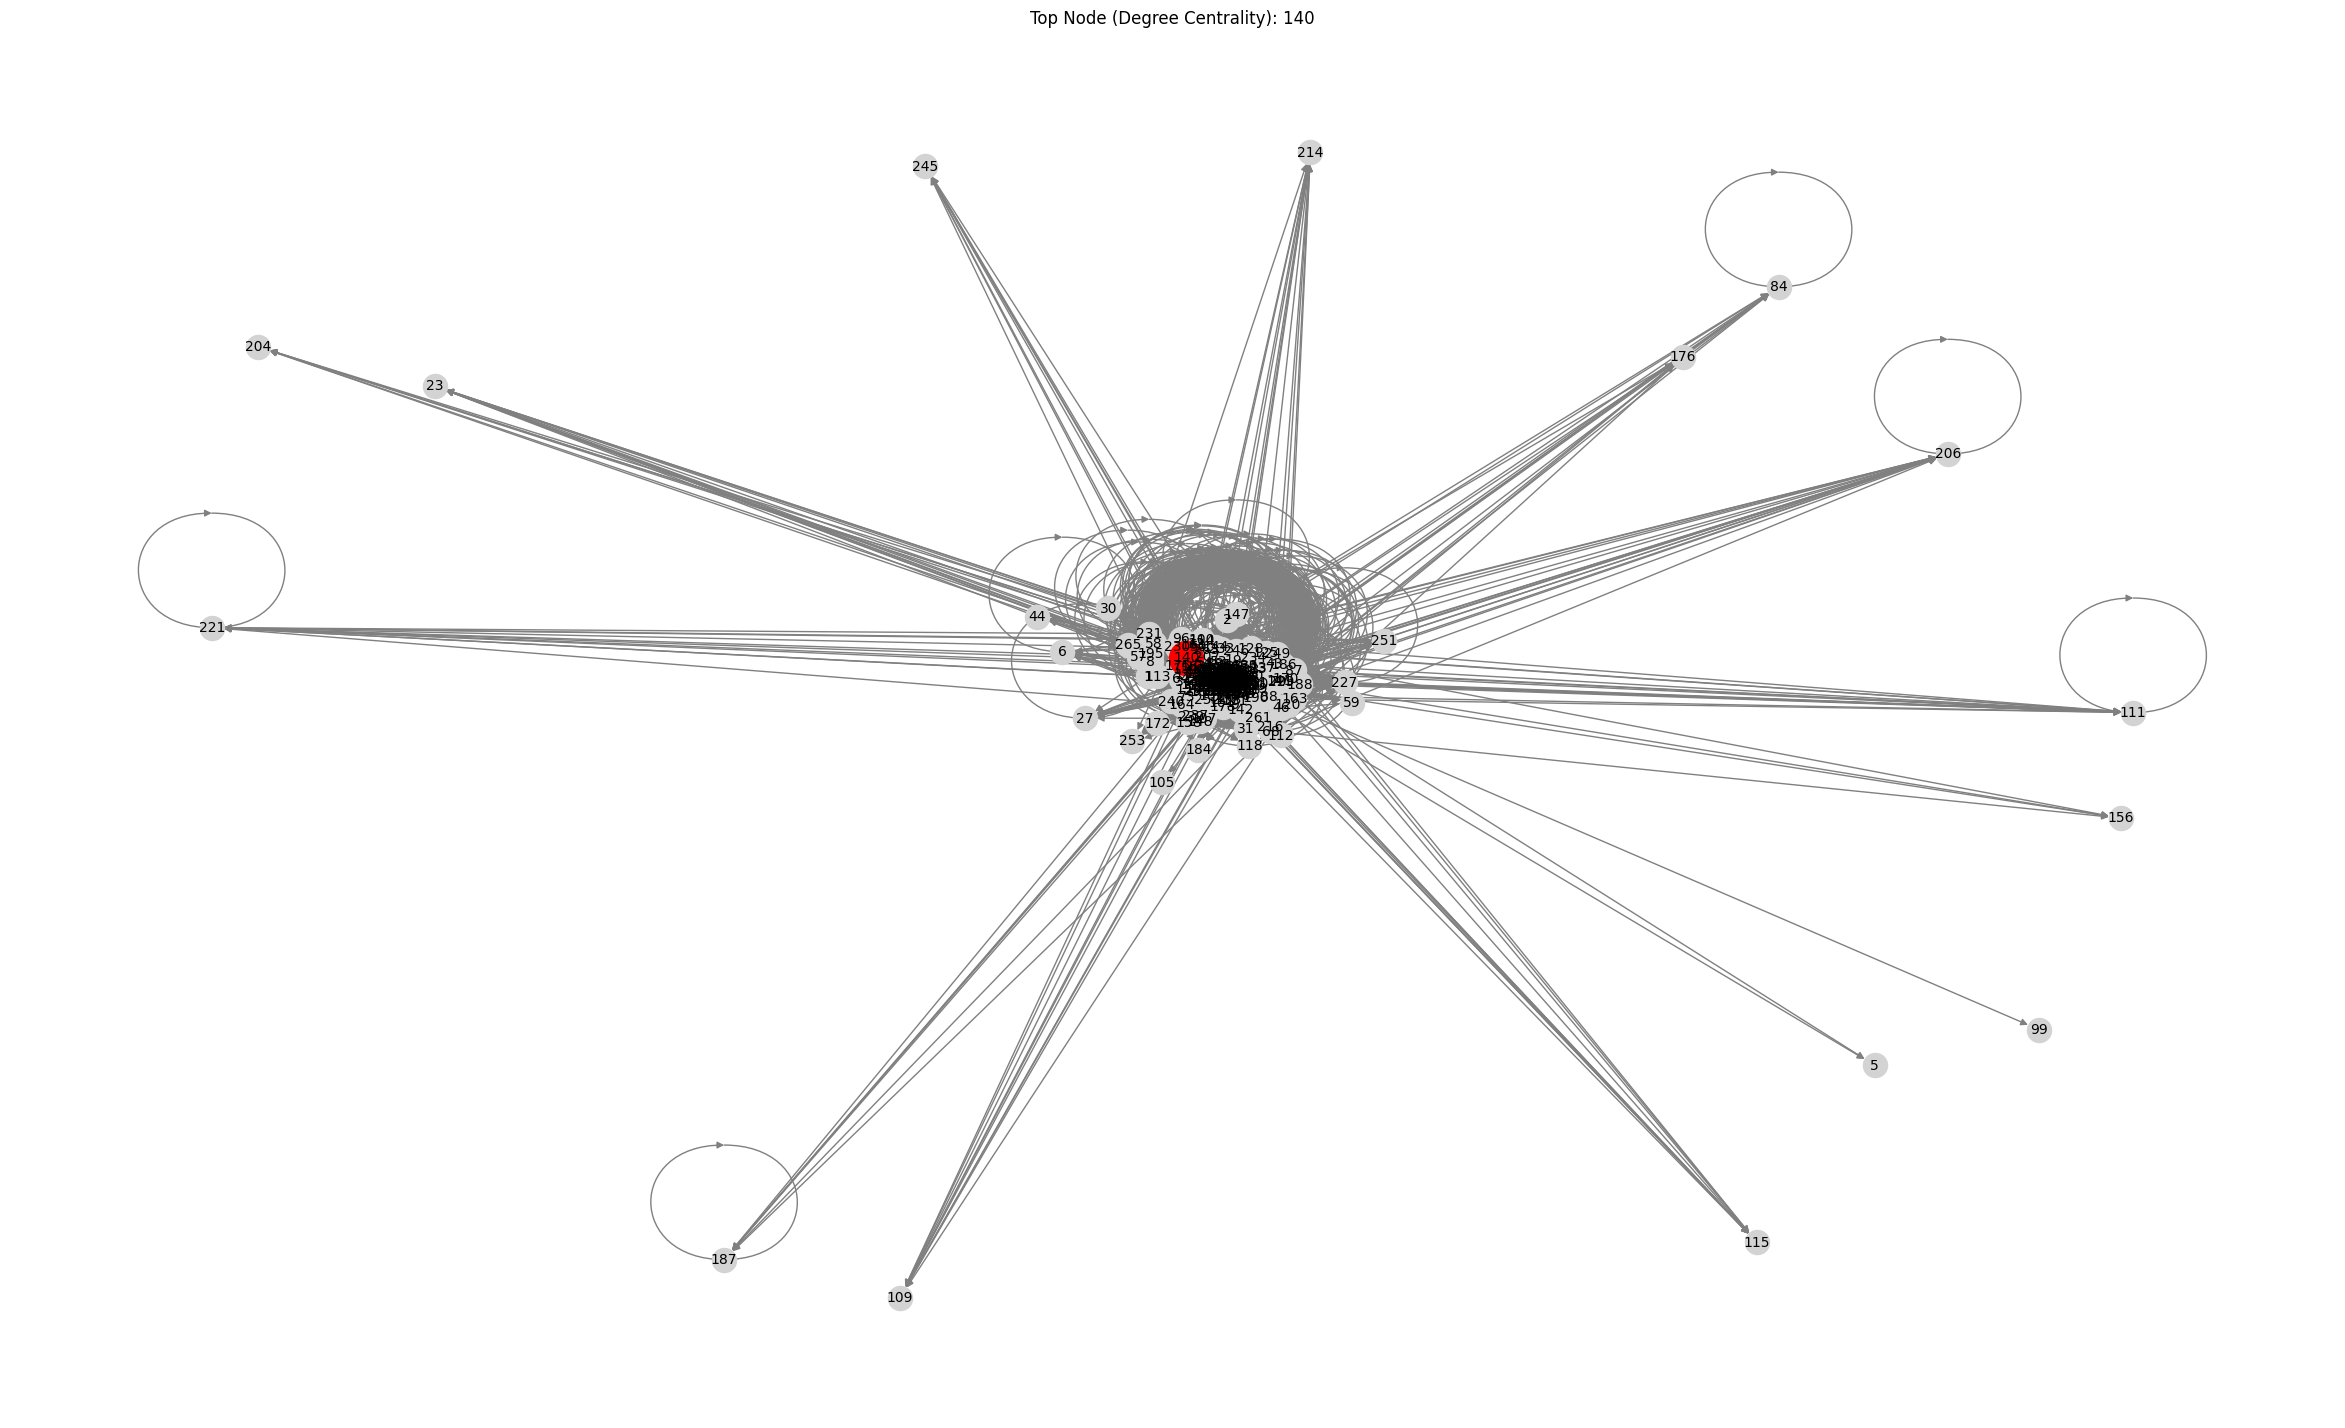

In [17]:
pos = nx.spring_layout(G_credit, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw(G_credit, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

nx.draw_networkx_nodes(G_credit, pos, nodelist=[top_degree_centrality], node_color="red", node_size=600)

plt.title(f"Top Node (Degree Centrality): {top_degree_centrality}")
plt.axis('off')
plt.show()

In [18]:
top_cc_trips = cc_trips.copy()
top_cc_trips = top_cc_trips[(top_cc_trips['PULocationID']==140) | (top_cc_trips['DOLocationID']==140)]

As for the top 10 trip counts within **node 140**, this zone is called Lennox Hill East, and has most of its rides going to/from zones Upper East Side North/South and Yorkville East/West. 

In [19]:
top_10 = top_cc_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone'}).drop(columns=['LocationID'])

,PULocationID,DOLocationID,payment_type,trip_count,PU_Borough,PU_Zone,DO_Borough,DO_Zone
0,140,236,Credit Card,4965,Manhattan,Lenox Hill East,Manhattan,Upper East Side North
1,237,140,Credit Card,4414,Manhattan,Upper East Side South,Manhattan,Lenox Hill East
2,236,140,Credit Card,4156,Manhattan,Upper East Side North,Manhattan,Lenox Hill East
3,140,237,Credit Card,3952,Manhattan,Lenox Hill East,Manhattan,Upper East Side South
4,140,263,Credit Card,3557,Manhattan,Lenox Hill East,Manhattan,Yorkville West
5,140,262,Credit Card,3415,Manhattan,Lenox Hill East,Manhattan,Yorkville East
6,162,140,Credit Card,3132,Manhattan,Midtown East,Manhattan,Lenox Hill East
7,262,140,Credit Card,2993,Manhattan,Yorkville East,Manhattan,Lenox Hill East
8,140,162,Credit Card,2885,Manhattan,Lenox Hill East,Manhattan,Midtown East
9,229,140,Credit Card,2823,Manhattan,Sutton Place/Turtle Bay North,Manhattan,Lenox Hill East


### Eigenvector Centrality

Looking at the node with the highest eigenvector centrality, we find that **node 236** is the most important node by this measure and it has 339 edges connected to it. However, **Node 237** closely follows in its eigenvector score before we have a steep drop off from the next node. 

In [20]:
sorted_eigenvector = sorted(nx.eigenvector_centrality(G_credit, weight='trip_count', max_iter=1000).items(), key=lambda x: x[1], reverse=True)

for node, centrality in sorted_eigenvector[:5]:
    print(f"Node {node}: {centrality}")
    print("Number of Edges:", G_credit.degree(node))
    print("------")

Node 236: 0.4416756729136076
Number of Edges: 339
------
Node 237: 0.4002923550150676
Number of Edges: 342
------
Node 161: 0.2540441945840572
Number of Edges: 372
------
Node 142: 0.22271859151344084
Number of Edges: 350
------
Node 239: 0.22160805902946695
Number of Edges: 304
------


Looking deeper into our top node, we see that **node 236** is the Upper East Side North. **Node 237** is the Upper East Side South and these areas combined accounts for a majority of the trips happening in Manhattan.

In [21]:
top_cc_trips = cc_trips.copy()
top_cc_trips = top_cc_trips[(top_cc_trips['PULocationID']==237) | (top_cc_trips['DOLocationID']==237)]

top_10 = top_cc_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone'}).drop(columns=['LocationID'])

,PULocationID,DOLocationID,payment_type,trip_count,PU_Borough,PU_Zone,DO_Borough,DO_Zone
0,237,236,Credit Card,18452,Manhattan,Upper East Side South,Manhattan,Upper East Side North
1,236,237,Credit Card,16340,Manhattan,Upper East Side North,Manhattan,Upper East Side South
2,237,237,Credit Card,11317,Manhattan,Upper East Side South,Manhattan,Upper East Side South
3,161,237,Credit Card,8476,Manhattan,Midtown Center,Manhattan,Upper East Side South
4,237,161,Credit Card,7156,Manhattan,Upper East Side South,Manhattan,Midtown Center
5,237,162,Credit Card,6231,Manhattan,Upper East Side South,Manhattan,Midtown East
6,237,141,Credit Card,5282,Manhattan,Upper East Side South,Manhattan,Lenox Hill West
7,162,237,Credit Card,5212,Manhattan,Midtown East,Manhattan,Upper East Side South
8,142,237,Credit Card,5043,Manhattan,Lincoln Square East,Manhattan,Upper East Side South
9,237,142,Credit Card,5004,Manhattan,Upper East Side South,Manhattan,Lincoln Square East


### Total Trip Counts by Location

Lets look at total trip counts regardless of the direction it was taken in. This means it can be either the pickup or dropoff location. When we do, we immediately see that both **nodes 236 and 237** are the highest in total trips within our credit card network. This was a great finding as before, we solely were looking at one direction in our exploratory analysis, showing that either JFK Airport (pickups) or the Upper East Side (dropoffs) were both the highest traveled trips in our network. We can now see that it is solely the Upper East Side regions. 

Another note is that our top 4 regions here match our results of the eigenvector score rankings, however, it does not solely mean that if something has the highest amount of trips it will rank highly. Our 5th placed rank here is **node 162** Midtown East, while the 5th place eigenvector score was for **node 239** Upper West Side South

In [22]:
locations_1 = cc_trips[['PULocationID', 'trip_count']].rename(columns={'PULocationID':'location_id'})
locations_2 = cc_trips[['DOLocationID', 'trip_count']].rename(columns={'DOLocationID':'location_id'})
pd.concat([locations_1, locations_2]).groupby('location_id').sum().reset_index().sort_values(by='trip_count', ascending=False).head(5)

,location_id,trip_count
231,236,228707
232,237,222157
157,161,202975
138,142,156783
158,162,154879


## Yellow Taxi Trips (Cash)

Our second network graph setup will be looking into cash transactions. We are again looking to measure a network's most important nodes using both degree and eigenvector centrality. The graph will be a directed, weighted graph using **trip_counts** as its weights and the direction of a **PULocationID** to **DOLocationID** trip. 

In [23]:
cash_trips = cleaned_trips_df[cleaned_trips_df['payment_type'] == 'Cash']
cash_trips.head()

,PULocationID,DOLocationID,payment_type,trip_count
0,1,1,Cash,12
3,1,48,Cash,1
9,1,265,Cash,5
13,3,3,Cash,6
56,3,242,Cash,1


The shape of our network is once again similar to the credit card network, where a majority of our nodes are centralized, with some nodes on the outskirts of the plot, leaning more to locations not traveled as often.

In [ ]:
G_cash = nx.from_pandas_edgelist(cash_trips, source='PULocationID', target='DOLocationID', 
                            edge_attr='trip_count', create_using=nx.DiGraph())

pos = nx.spring_layout(G_cash, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw_networkx_nodes(G_cash, pos, node_size=300, node_color="skyblue")
nx.draw_networkx_edges(G_cash, pos, width=0.15)
nx.draw_networkx_labels(G_cash, pos, font_size=8, font_weight="bold")

plt.title("NYC Cash Taxi Trips Network (Directed, Weighted)")
plt.show()

### Degree Centrality

Looking at the node with the highest degree centrality, we find that **node 132** is the most important node by this measure and it had 380 edges connected to it. 

In [ ]:
top_degree_centrality = max(nx.degree_centrality(G), key=nx.degree_centrality(G).get)
print(f"Highest Degree Centrality: {top_degree_centrality}")
print("Number of Edges:", G_cash.degree(132))

Highlighting **node 132** we see it near the center of our graph

In [ ]:
pos = nx.spring_layout(G_cash, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw(G_cash, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

nx.draw_networkx_nodes(G_cash, pos, nodelist=[top_degree_centrality], node_color="red", node_size=600)

plt.title(f"Top Node (Degree Centrality): {top_degree_centrality}")
plt.axis('off')
plt.show()

In [ ]:
top_cash_trips = cash_trips.copy()
top_cash_trips = top_cash_trips[(top_cash_trips['PULocationID']==132) | (top_cash_trips['DOLocationID']==132)]

Interestingly enough **node 132** is JFK Airport and most trips are being picked up from the airport.

In [ ]:
top_10 = top_cash_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone'}).drop(columns=['LocationID'])

### Eigenvector Centrality

Looking at the node with the highest eigenvector centrality, we find that **node 237** is the most important node by this measure and it has 245 edges connected to it. Once again, **node 236** is close in score. This matches the same results with our credit card network.

In [ ]:
sorted_eigenvector = sorted(nx.eigenvector_centrality(G_cash, weight='trip_count', max_iter=1000).items(), key=lambda x: x[1], reverse=True)

for node, centrality in sorted_eigenvector[:5]:
    print(f"Node {node}: {centrality}")
    print("Number of Edges:", G_cash.degree(node))
    print("------")

In [ ]:
top_cash_trips = cash_trips.copy()
top_cash_trips = top_cash_trips[(top_cash_trips['PULocationID']==237) | (top_cash_trips['DOLocationID']==237)]

top_10 = top_cash_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone'}).drop(columns=['LocationID'])

### Total Trip Counts by Location

As we look at total trips in either direction for a node, we see JFK Airport clearly has the most trips in general, which follows our degree centrality measure

In [ ]:
locations_1 = cash_trips[['PULocationID', 'trip_count']].rename(columns={'PULocationID':'location_id'})
locations_2 = cash_trips[['DOLocationID', 'trip_count']].rename(columns={'DOLocationID':'location_id'})
pd.concat([locations_1, locations_2]).groupby('location_id').sum().reset_index().sort_values(by='trip_count', ascending=False).head(5).merge(location_df, left_on='location_id', right_on='LocationID').drop(columns=['LocationID'])

## Conclusion
